In [1]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf
from tensorflow.keras import layers 
from tensorflow.keras import losses

In [2]:
dataset_dir = os.path.join("C:/Users/Admin/Desktop/TensorFlow/stack_overflow_16k")

In [3]:
os.listdir(dataset_dir)

['README.md', 'test', 'train']

In [4]:
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['csharp', 'java', 'javascript', 'python']

In [5]:
# simple_file = os.path.join(train_dir,'python/1.txt')

# with open(simple_file) as f:
#     print(f.read())

In [6]:
raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    "C:/Users/Admin/Desktop/TensorFlow/stack_overflow_16k/train",
    validation_split=0.2,
    subset="training",
    batch_size=32,
    seed=42
)

Found 8000 files belonging to 4 classes.
Using 6400 files for training.


In [7]:
# for text_batch, label_batch in raw_train_ds.take(1):
#     for i in range(2):
#         print("Review: ",text_batch.numpy()[i])
#         print("Label: ",label_batch.numpy()[i])

In [8]:
# print("label 0 name: ", raw_train_ds.class_names[0])
# print("label 1 name: ", raw_train_ds.class_names[1])
# print("label 2 name: ", raw_train_ds.class_names[2])
# print("label 3 name: ", raw_train_ds.class_names[3])

In [9]:
raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    "C:/Users/Admin/Desktop/TensorFlow/stack_overflow_16k/train",
    validation_split=0.2,
    subset="validation",
    batch_size=32,
    seed=42

)

Found 8000 files belonging to 4 classes.
Using 1600 files for validation.


In [10]:
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    "C:/Users/Admin/Desktop/TensorFlow/stack_overflow_16k/train",
    batch_size=32
)

Found 8000 files belonging to 4 classes.


In [11]:
def custom_standarization(input):
    lowercase = tf.strings.lower(input)
    stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
    return tf.strings.regex_replace(stripped_html,'[%s]' % re.escape(string.punctuation),'')

In [12]:
max_feature = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize=custom_standarization,
    max_tokens = max_feature,
    output_sequence_length=sequence_length,
    output_mode='int'
)

In [13]:
train_text = raw_train_ds.map(lambda x, y:x)
vectorize_layer.adapt(train_text)


In [14]:
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

In [15]:
# text_batch, label_batch = next(iter(raw_train_ds))
# first_review, first_label = text_batch[0], label_batch[0]
# raw_train_ds.class_names[first_label]

In [16]:
train_dir = raw_train_ds.map(vectorize_text)
val_dir = raw_val_ds.map(vectorize_text)
test_dir = raw_test_ds.map(vectorize_text)

In [17]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_dir.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_dir.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_dir.cache().prefetch(buffer_size=AUTOTUNE)

In [18]:
embedding_dim = 16

model = tf.keras.Sequential([
    layers.Embedding(max_feature + 1, embedding_dim),
    layers.Dropout(0.2),
    layers.GlobalAveragePooling1D(),
    layers.Dropout(0.2),
    layers.Dense(4)
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          160016    
                                                                 
 dropout (Dropout)           (None, None, 16)          0         
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 4)                 68        
                                                                 
Total params: 160,084
Trainable params: 160,084
Non-trainable params: 0
__________________________________________________

In [19]:
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer = 'adam',
    metrics = ['accuracy']
)

In [20]:

history = model.fit(
train_ds,
validation_data=val_ds,
    epochs=10
)

Epoch 1/10
200/200 [==============================] - 2s 8ms/step - loss: 1.3788 - accuracy: 0.3562 - val_loss: 1.3679 - val_accuracy: 0.5000
Epoch 2/10
200/200 [==============================] - 0s 2ms/step - loss: 1.3502 - accuracy: 0.4836 - val_loss: 1.3292 - val_accuracy: 0.5469
Epoch 3/10
200/200 [==============================] - 0s 2ms/step - loss: 1.2976 - accuracy: 0.5384 - val_loss: 1.2683 - val_accuracy: 0.5956
Epoch 4/10
200/200 [==============================] - 0s 2ms/step - loss: 1.2297 - accuracy: 0.5783 - val_loss: 1.1983 - val_accuracy: 0.6162
Epoch 5/10
200/200 [==============================] - 1s 3ms/step - loss: 1.1567 - accuracy: 0.6111 - val_loss: 1.1290 - val_accuracy: 0.6500
Epoch 6/10
200/200 [==============================] - 1s 3ms/step - loss: 1.0877 - accuracy: 0.6508 - val_loss: 1.0639 - val_accuracy: 0.6744
Epoch 7/10
200/200 [==============================] - 1s 3ms/step - loss: 1.0216 - accuracy: 0.6816 - val_loss: 1.0045 - val_accuracy: 0.6938
Epoch 

# Evolute the model

In [21]:
loss, accuracy =model.evaluate(test_ds)
print("Loss: ", loss)
print("Accuracy: ",accuracy)

250/250 [==============================] - 1s 5ms/step - loss: 0.8337 - accuracy: 0.7754
Loss:  0.8336604237556458
Accuracy:  0.7753750085830688


In [22]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

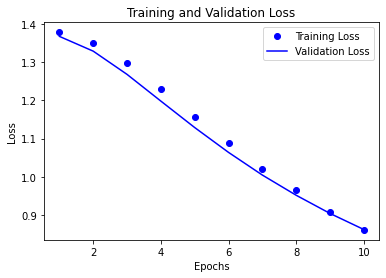

In [23]:
acc = history_dict['accuracy']
val_ac = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc)+1)

#'bo' is for blue dot
plt.plot(epochs, loss, 'bo', label='Training Loss')
#b is for solid blue line

plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

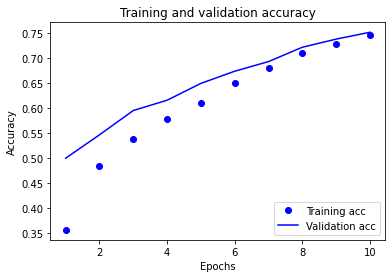

In [24]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_ac, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()